<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction to Data Science
    <div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

# 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# 2. Read data

In [2]:
movie_df = pd.read_csv('./../data/processed.csv')
movie_df

,Name,Released year,Genre,Director,Runtime (h),Score,Status,Language,Budget ($),Revenue ($)
0,Fast X,2023,"'Action', 'Crime', 'Thriller'",Dan Mazeau,2.37,72.0,Released,English,340000000.0,704709660.0
1,Trolls Band Together,2023,"'Animation', 'Family', 'Music', 'Fantasy', 'Co...",Thomas Dam,1.53,72.0,Released,English,95000000.0,173800000.0
2,Robot Apocalypse,2021,"'Science Fiction', 'Action'",Marcus Friedlander,1.45,21.0,Released,English,NaN,NaN
3,Five Nights at Freddy's,2023,"'Horror', 'Mystery'",Emma Tammi,1.83,78.0,Released,English,20000000.0,286700000.0
4,Oppenheimer,2023,"'Drama', 'History'",Christopher Nolan,3.02,81.0,Released,English,100000000.0,951000000.0
...,...,...,...,...,...,...,...,...,...,...
4995,Secret in Their Eyes,2015,"'Thriller', 'Mystery', 'Drama', 'Crime'",Billy Ray,1.85,64.0,Released,English,19500000.0,34854990.0
4996,The Vatican Tapes,2015,"'Thriller', 'Horror'",Mark Neveldine,1.52,53.0,Released,English,13000000.0,1784763.0
4997,Song to Song,2017,"'Romance', 'Drama', 'Music'",Terrence Malick,2.15,55.0,Released,English,10000000.0,1710528.0
4998,Divine Intervention,2023,'Comedy',Pedro Pablo Ibarra,1.67,82.0,Released,Spanish; Castilian,NaN,NaN


# 3. Feature engineering
- Transform categorical variables using one-hot encoding and label encoding
- Create a `Success` column to classify movies as `Successful` or `Unsuccessful`:
  - `Successful` movies: profit rate > 50% and the `Score` is greater than the median score of all movies

In [3]:
df = movie_df[['Genre', 'Runtime (h)', 'Score', 'Language', 'Budget ($)', 'Revenue ($)']].dropna()

#Transform categorical variables using one-hot encoding and label encoding
one_hot_df = pd.DataFrame()
def splitGenre(s):
    return s.split(', ')
genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()
genre_dummy = pd.get_dummies(genre_stack).groupby(level = 0).sum()
genre_dummy.columns = ['Genre_' + col.replace("'", "") for col in genre_dummy.columns]
df = pd.concat([genre_dummy, df], axis = 1)

label_encoder=LabelEncoder()
df['Language_encoded'] = label_encoder.fit_transform(df['Language'])

df = df.drop(['Genre', 'Language'], axis=1)

#Create a Success column
profit_percentage = (df['Revenue ($)'] - df['Budget ($)']) / df['Budget ($)']

df['Success'] = df.apply(lambda row: 'Successful' if row['Score'] >= df['Score'].median()
                         and (row['Revenue ($)'] - row['Budget ($)']) / row['Budget ($)'] >= 0.5 else 'Unsuccessful', axis=1)
df

C:\Users\PC\AppData\Local\Temp\ipykernel_13448\555933024.py:7: FutureWarning: using <class 'pandas.core.series.Series'> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()
C:\Users\PC\AppData\Local\Temp\ipykernel_13448\555933024.py:7: FutureWarning: using <class 'pandas.core.series.Series'> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  genre_stack = df['Genre'].apply(splitGenre).agg(pd.Series).stack().agg(pd.Series).stack()


,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_History,Genre_Horror,...,Genre_TV Movie,Genre_Thriller,Genre_War,Genre_Western,Runtime (h),Score,Budget ($),Revenue ($),Language_encoded,Success
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,2.37,72.0,340000000.0,704709660.0,5,Successful
1,0,0,1,1,0,0,1,1,0,0,...,0,0,0,0,1.53,72.0,95000000.0,173800000.0,5,Successful
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1.83,78.0,20000000.0,286700000.0,5,Successful
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,3.02,81.0,100000000.0,951000000.0,5,Successful
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.80,65.0,40000000.0,8000000.0,5,Unsuccessful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1.62,56.0,9000000.0,146863.0,5,Unsuccessful
4992,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1.85,67.0,23000000.0,19652638.0,5,Unsuccessful
4995,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1.85,64.0,19500000.0,34854990.0,5,Unsuccessful
4996,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1.52,53.0,13000000.0,1784763.0,5,Unsuccessful


# 4. Data preparation

In [4]:
X = df.drop('Success', axis=1)  # Features
y = df['Success']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Training model & Prediction

In [5]:
models = [RandomForestClassifier(), SVC(), KNeighborsClassifier(), MultinomialNB()]
model_names = ['Random Forest', 'SVM', 'KNN', 'Multinomial Naive Bayes']
y_preds = {}

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred

# 6. Evaluation
- We use 4 metrics to evaluate the performance of models:
    - **Accuracy**: It measures the percentage of correctly predicted samples out of the total number of samples
    - **Precision**: It calculates the ratio of true positive predictions to the total number of positive predictions
    - **Recall**: It calculates the ratio of true positive predictions to the total number of actual positive samples
    - **F1-score**: It is the harmonic mean of precision and recall. The F1-score is a balanced measure of accuracy and sensitivity

In [6]:
pos_label = 'Successful'

results = []
for model in model_names:
    y_pred = y_preds[model]
    accuracy = accuracy_score(y_test, y_pred).__round__(4)
    precision = precision_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    recall = recall_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    f1score = f1_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    results.append([accuracy, precision, recall, f1score])

df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 score'])

df_results.index = model_names
df_result = df_results.transpose()
df_result

,Random Forest,SVM,KNN,Multinomial Naive Bayes
Accuracy,0.9646,0.6751,0.6734,0.7121
Precision,0.9377,0.7055,0.6447,0.6679
Recall,0.9846,0.4423,0.5654,0.6808
F1 score,0.9606,0.5437,0.6025,0.6743


# 7. Observation
- So **Random Forest** has high performance, but SVM, KNN and Multinomial Naive Bayes performance is still low
- Because we are applying a classification model, we will improve the model by handling **Imbalanced data**

# 8. Improve model by handling Imbalanced data

## &nbsp;8.1 Handle imbalanced data

In [7]:
count = y.value_counts()
print(count)
print('Imbalance ratio: ' + str(count['Successful']/count['Unsuccessful']))

Success
Unsuccessful    1760
Successful      1209
Name: count, dtype: int64
Imbalance ratio: 0.6869318181818181


- The sample has an imbalance rate of **0.687**, which means that the number of samples in the `Successful` class is 0.687 times the number of samples in the `Unsuccessful` class.
- This ratio shows a difference in the data distribution between two classification classes
- To handle imbalanced data, we use the **Synthetic Minority Over-sampling Technique (SMOTE)** method to combine the closest samples and create new synthetic samples in the `Success` class

In [8]:
# Handle imbalance data
smote = SMOTE()
X, y = smote.fit_resample(X, y)
count = y.value_counts()

## &nbsp;8.2 Prediction & evaluation with new data

In [9]:
#Prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_preds = {}
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred

#Evaluation
pos_label = 'Successful'

results = []
for model in model_names:
    y_pred = y_preds[model]
    accuracy = accuracy_score(y_test, y_pred).__round__(4)
    precision = precision_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    recall = recall_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    f1score = f1_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    results.append([accuracy, precision, recall, f1score])

df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 score'])

df_results.index = model_names
df_result = df_results.transpose()
df_result

,Random Forest,SVM,KNN,Multinomial Naive Bayes
Accuracy,0.9702,0.6705,0.7102,0.7045
Precision,0.9421,0.6519,0.6797,0.7018
Recall,1.0000,0.6901,0.7632,0.6813
F1 score,0.9702,0.6705,0.7190,0.6914


## &nbsp;8.3 Observation
- The performance of all models has improved but is still not high (except Random Forest), so we will proceed with **Fine-tuning the hyperparameters** in the SVM, KNN and Multinomial Naive Bayes models

# 9. Improve the model by fine-tuning hyperparameters

## &nbsp;9.1 Method
 - Grid Search CV (Cross-Validation) is a hyperparameter search method which combines Grid Search and Cross-Validation to evaluate model performance with different hyperparameter values
 - Cross-Validation is a method of evaluating model performance by dividing the data set into subsets (folds), training the model on the training subsets and evaluating on the test subsets
 - In Grid Search CV, we define a set of hyperparameter values that we want to test for our model. Grid Search CV then generates all possible combinations from that set of hyperparameter values and performs Cross-Validation on each combination

## &nbsp;9.2 Define parameter grid

In [10]:
#Create a param grid from each model's hyperparameter set  
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 
                  'gamma': ['scale', 'auto']}
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 
                  'weights': ['uniform', 'distance'], 
                  'metric': ['euclidean', 'manhattan']}
param_grid_mnb = {'alpha': [0.1, 0.5, 1, 2],
                  'fit_prior': [True, False], 
                  'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],}
params = [param_grid_svm, param_grid_knn, param_grid_mnb]

## &nbsp;9.3 Find the best hyperparameter combination

In [11]:
#Use GridSearchCv to find the best combination of parameters
best_parameters = {}
for model, name, param in zip(models[1:], model_names[1:], params):
    grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_parameters[name] = grid_search.best_params_
    
for name, best_param in best_parameters.items():
    print(f"Best parameters for {name}: {best_param}")

Best parameters for SVM: {'C': 100, 'gamma': 'scale'}
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
Best parameters for Multinomial Naive Bayes: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}


## &nbsp;9.4 Prediction & evaluation with the best parameters

In [12]:
#Prediction
for model, name in zip(models[1:], model_names[1:]):
    model.set_params(**best_parameters[name])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred

#Evaluation
results = []
for model in model_names:
    y_pred = y_preds[model]
    accuracy = accuracy_score(y_test, y_pred).__round__(4)
    precision = precision_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    recall = recall_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    f1score = f1_score(y_test, y_pred, pos_label=pos_label).__round__(4)
    results.append([accuracy, precision, recall, f1score])

df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 score'])

df_results.index = model_names
df_result = df_results.transpose()
df_result

,Random Forest,SVM,KNN,Multinomial Naive Bayes
Accuracy,0.9702,0.6903,0.7301,0.7045
Precision,0.9421,0.6372,0.6827,0.7018
Recall,1.0000,0.8421,0.8304,0.6813
F1 score,0.9702,0.7254,0.7493,0.6914


# 10. Result & Models comparison

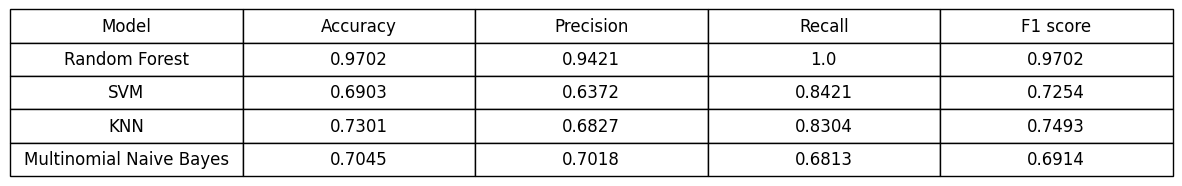

In [13]:
#Result
df_results.insert(0, 'Model', df_results.index)
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2)
plt.show()

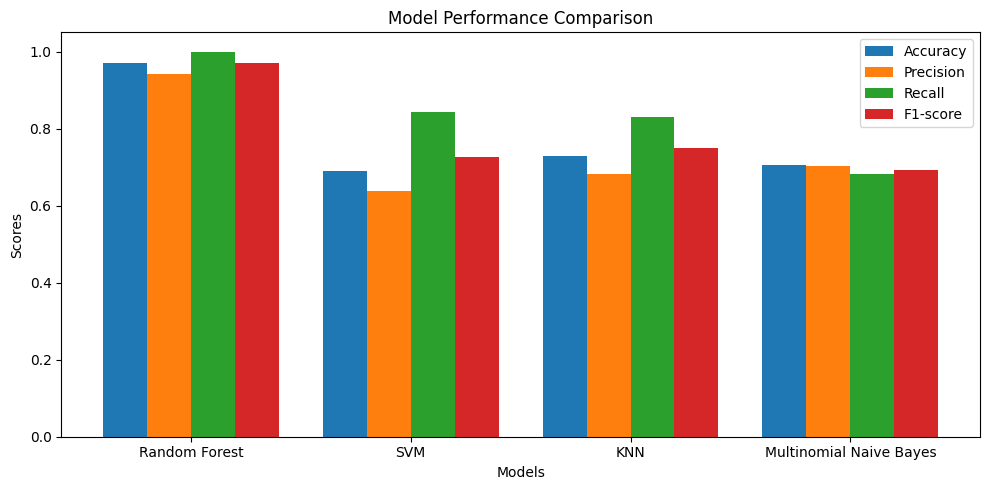

In [14]:
#Comparison
accuracy = [item[0] for item in results]
precision = [item[1] for item in results]
recall = [item[2] for item in results]
f1_score = [item[3] for item in results]

bar_width = 0.2

index = np.arange(len(results))

plt.figure(figsize=(10, 5))

plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + (1 * bar_width), precision, bar_width, label='Precision')
plt.bar(index + (2 * bar_width), recall, bar_width, label='Recall')
plt.bar(index + (3 * bar_width), f1_score, bar_width, label='F1-score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(index + (1.5 * bar_width), model_names)

plt.legend()
plt.tight_layout()
plt.show()

# 11. Conclusion

- After improving models **SVM**, **KNN** and **Multinomial Naive Bayes**, model **Random Forest** is still the model with the best performance.
- **SVM**, **KNN** and **Multinomial Naive Bayes** have increased performance by **handling imbalanced data** and **finding the best hyperparameters**. However, the performance is still not high enough, possible reasons are: the data is not large enough or not good enough or the model's algorithms are not appropriate,...